In [42]:
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools

In [43]:
checkpoints = [
    "henryscheible/bert-large-uncased_stereoset_finetuned",
    "henryscheible/bert-large-uncased_winobias_finetuned",
    "henryscheible/bert-large-uncased_crows_pairs_finetuned",
    # "henryscheible/gpt2_stereoset_finetuned",
    # "henryscheible/gpt2_winobias_finetuned",
    # "henryscheible/gpt2_crows_pairs_finetuned",
    # "henryscheible/xlnet-base-cased_stereoset_finetuned",
    "henryscheible/xlnet-base-cased_winobias_finetuned",
    # "henryscheible/xlnet-base-cased_crows_pairs_finetuned",
]

In [49]:
from transformers import AutoConfig
from plmbias.models import ModelEnvironment

data = {}
for checkpoint in checkpoints:
    print(f"https://huggingface.co/{checkpoint}/raw/main/ss_ablation_results.json")
    data[checkpoint] = json.loads(requests.get(f"https://huggingface.co/{checkpoint}/raw/main/ss_ablation_results.json").text)
    # model_env = ModelEnvironment.from_pretrained(checkpoint)
    config = AutoConfig.from_pretrained(checkpoint)

    data[checkpoint]["mask_shape"] = config.num_attention_heads * config.num_hidden_layers
    data[checkpoint]["num_attention_heads"] = config.num_attention_heads
    data[checkpoint]["num_hidden_layers"] = config.num_hidden_layers


https://huggingface.co/henryscheible/bert-large-uncased_stereoset_finetuned/raw/main/ss_ablation_results.json
https://huggingface.co/henryscheible/bert-large-uncased_winobias_finetuned/raw/main/ss_ablation_results.json
https://huggingface.co/henryscheible/bert-large-uncased_crows_pairs_finetuned/raw/main/ss_ablation_results.json
https://huggingface.co/henryscheible/xlnet-base-cased_winobias_finetuned/raw/main/ss_ablation_results.json


In [45]:
data.keys()

dict_keys(['henryscheible/bert-large-uncased_stereoset_finetuned', 'henryscheible/bert-large-uncased_winobias_finetuned', 'henryscheible/bert-large-uncased_crows_pairs_finetuned', 'henryscheible/xlnet-base-cased_winobias_finetuned'])

In [46]:
checkpoints = list(data.keys())

In [50]:
from huggingface_hub import HfApi
import torch

def plot(checkpoint):
    sns.set()
    sns.set(font_scale=1.2)
    # ss_hline = float(data[checkpoint]["base_ss"])
    # lm_hline = float(data[checkpoint]["base_lm"])

    df = pd.DataFrame({
        'heads': np.arange(data[checkpoint]['mask_shape'] + 1),
        'ss': np.flip(data[checkpoint]["bottom_up_lm"]),
        'lms': np.flip(data[checkpoint]["bottom_up_ss"]),
        'Shapley Value': np.flip([list(np.sort(np.array(data[checkpoint]["contribs"])))[0]] + \
            list(np.sort(np.array(data[checkpoint]["contribs"]))))
    })

    df['inverse_ss'] = 100 - df['ss']
    df['icat'] = df['lms'] * (df[['ss', 'inverse_ss']].min(axis=1)) / 50

    # df['bottom_up_lm'] = df['bottom_up_lm'] / lm_hline
    # df['bottom_up_ss'] = df['bottom_up_ss'] / ss_hline
    # contribs = np.asarray(data[checkpoint]["contribs"])
    # vline = (contribs < 0).sum()

    ax = sns.lineplot(x='heads', y='value', hue='variable',
                data=pd.melt(df[['heads', 'lms', 'ss', 'icat']], ['heads']))
    ax2 = ax.twinx()
    ln2 = sns.lineplot(x='heads', y='value', hue='variable',
                 data=pd.melt(df[['heads', 'Shapley Value']], ['heads']), ax=ax2, palette=["#c44e52"])
    ax.set(xlabel="Number of Pruned Attention Heads", ylabel="Stereotype and Language Modeling Scores (ss/lms/icat)")
    ax2.set(ylabel="Attention-Head Contribution Score (Shapley Value)")
    lns1, labs1 = ax.get_legend_handles_labels()
    lns2, labs2 = ax2.get_legend_handles_labels()
    lns = lns1 + lns2
    labs = labs1 + labs2
    ax.legend(lns, labs, loc="upper right", title="")
    ax2.get_legend().remove()
    # ax.axvline(vline, 0, 100)
    # ax.axvline(109, 0, 100, color="green")
    ax.axhline(df['icat'][0], 0, data[checkpoint]['mask_shape'], color="#55a868")
    ax.axhline(50, 0, data[checkpoint]['mask_shape'], color="#dd8452")

    sorted_heads = np.argsort(data[checkpoint]["contribs"])
    best_mask = np.zeros(data[checkpoint]['mask_shape'])
    for head in sorted_heads[np.argmax(df["icat"]):]:
        best_mask[head] = 1
    print(f"{(best_mask == 1).sum()} heads")
    print(f"ICAT Pruned: {df['icat'][data[checkpoint]['mask_shape']-(best_mask == 1).sum()]}, SS pruned: {df['ss'][data[checkpoint]['mask_shape']-(best_mask == 1).sum()]}")
    print(f"ICAT Base: {df['icat'][0]}, SS Base: {df['ss'][0]}")
    res = {
        "heads_preserved_at_max_icat": int((best_mask == 1).sum()),
        "icat_pruned": df['icat'][data[checkpoint]['mask_shape']-(best_mask == 1).sum()],
        "ss_pruned": df['ss'][data[checkpoint]['mask_shape']-(best_mask == 1).sum()],
        "icat_base": df['icat'][0],
        "ss_base": df['ss'][0]
    }
    model_name = checkpoint.split("/")[1]
    with open(f"results/{model_name}_ss_ablation_stats.json", "w") as f:
        f.write(json.dumps(res, indent=4))
    pallete = sns.color_palette()
    print(pallete.as_hex())
    plt.savefig(f"results/{model_name}_ss_ablation.pdf", bbox_inches="tight", format="pdf")
    api = HfApi()
    api.upload_file(
    path_or_fileobj=f"results/{model_name}_ss_ablation_stats.json",
    path_in_repo=f"ss_ablation_stats.json",
    repo_id=checkpoint,
    repo_type="model")
    api.upload_file(
    path_or_fileobj=f"results/{model_name}_ss_ablation.pdf",
    path_in_repo=f"ss_ablation.pdf",
    repo_id=checkpoint,
    repo_type="model")
    plt.show()

35 heads
ICAT Pruned: 54.70557583912883, SS pruned: 49.73972148815474
ICAT Base: 44.49535041150719, SS Base: 50.873099766854935
['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


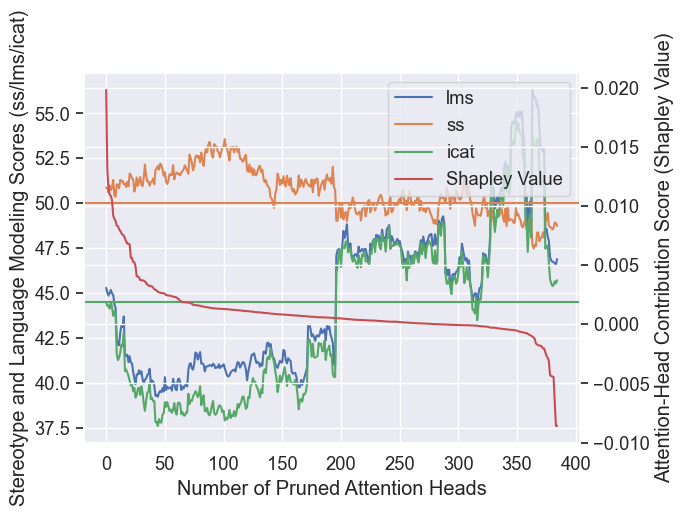

329 heads
ICAT Pruned: 49.72958792922659, SS pruned: 49.85926476686098
ICAT Base: 47.78589482379175, SS Base: 49.520604455224685
['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


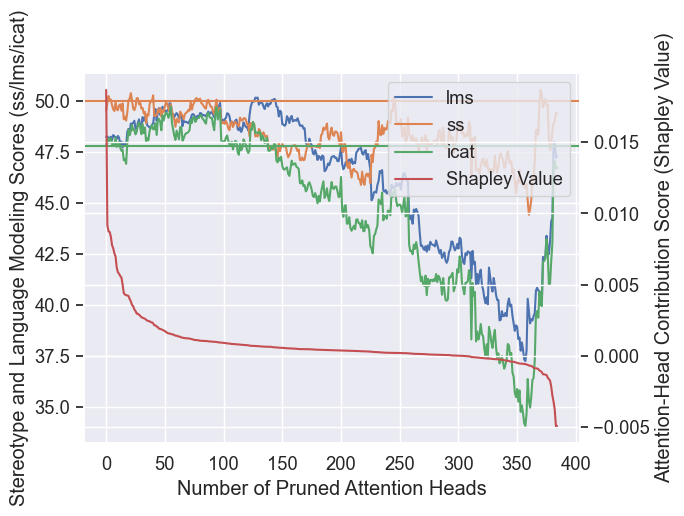

309 heads
ICAT Pruned: 50.51054860980168, SS pruned: 50.758399521560435
ICAT Base: 45.934908690486644, SS Base: 51.629449136664014
['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


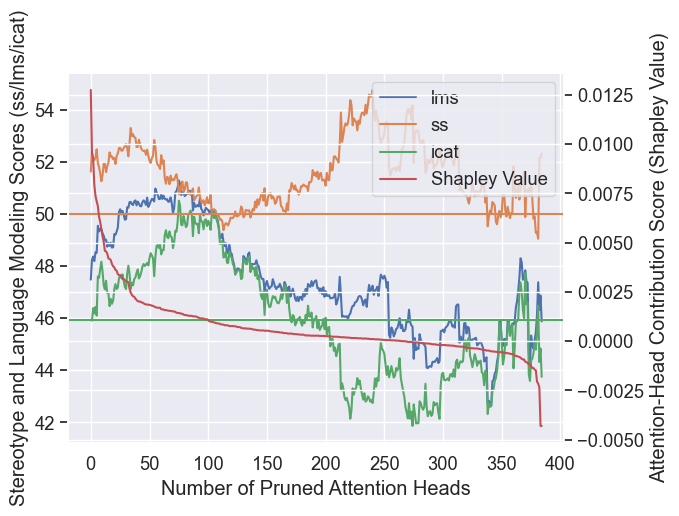

1 heads
ICAT Pruned: 58.26550239308289, SS pruned: 50.269198198584284
ICAT Base: 52.99253411229701, SS Base: 47.55278979403236
['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


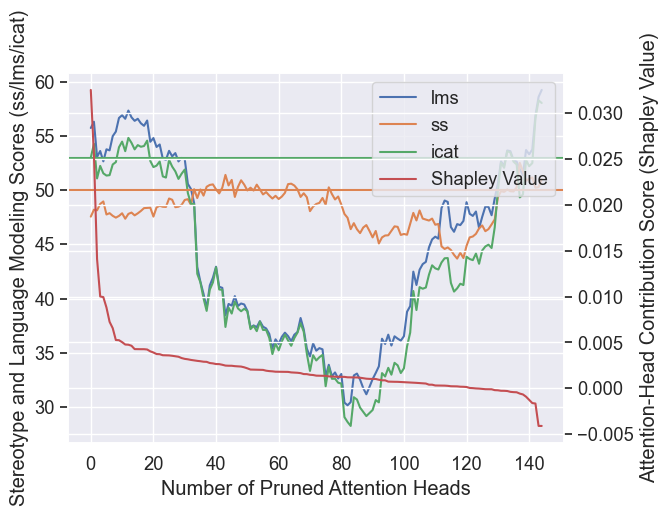

In [51]:
for checkpoint in checkpoints:
    plot(checkpoint)